In [32]:
import sys
from pandas.core.frame import DataFrame
import requests
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings


,ID,Date,pm10_mean,pm25_mean,pm10_max,pm25_max,pm10_min,pm25_min


In [34]:
# Fetch the api
# http://dhhagan.github.io/py-openaq/api.html
api = openaq.OpenAQ()

def measurement_to_csv(city,date_from,date_to):
    '''
    This function takes in a city, parameter and date and writes data into a csv.file
    Input:
        city: name of a city (string)
        ???parameter: List of strings that represent the parameters wanted to calculate
        date_from: measurments after this date will be calculated
        date_to: Measures until this date will be calculated
    '''

    # Number of days we want measurements for
    day_diff = (date_to - date_from).days

    # Number of 30 day blocks in our range
    number_months = day_diff // 30

    start = date_from
    
    # Add measurements to csv file 30 days at a time
    # An extra iteration for the remaining <30 days
    for n in range(number_months + 1):
        end = start + dt.timedelta(days = 30)
         # Fetch the data from the measurment api
        df = api.measurements(city = city, df = True, limit = 30000, parameter = ["pm25", "pm10"],
                              date_from = start, date_to = end)
        start = end

        ## Data prepping 

        # change the index
        df.index.name = 'Date.local'
        df.reset_index(inplace=True)
        df['Date'] = df['Date.local'].dt.strftime('%Y-%m-%d')
        df['value'] = df['value'].astype(float, errors = 'raise')

        # Calculate mean, max and min value for each date
        Result_mean = df.groupby(['Date', 'parameter'],as_index=False)['value'].mean()
        Result_max = df.groupby(['Date', 'parameter'],as_index=False)['value'].max()
        Result_min = df.groupby(['Date', 'parameter'],as_index=False)['value'].min()

        # Pivot the tables to wide format
        ResultWide_mean = Result_mean.pivot_table(index='Date',columns='parameter', values='value')
        ResultWide_max = Result_max.pivot_table(index='Date',columns='parameter', values='value')
        ResultWide_min = Result_min.pivot_table(index='Date',columns='parameter', values='value')

        # Rename the columns to distinguish
        ResultWide_mean.rename(columns={"pm10": 'pm10_mean', 'pm25': 'pm25_mean'}, inplace=True)
        ResultWide_max.rename(columns={"pm10": 'pm10_max', 'pm25': 'pm25_max'}, inplace=True)
        ResultWide_min.rename(columns={"pm10": 'pm10_min', 'pm25': 'pm25_min'}, inplace=True)

        # Join mean and max first
        df_first_join = pd.merge(ResultWide_mean, ResultWide_max, left_index=True, right_index=True)

        # Join now to min
        ResultWide = pd.merge(df_first_join, ResultWide_min, left_index=True, right_index=True)

        # Change the index
        ResultWide.index.name = 'Date'
        ResultWide.reset_index(inplace=True)
        ResultWide.index.name = 'ID'

        # Write to a file
        if n == 0:  
            Path = f'Data_measurements/{city}.csv'
            ResultWide.to_csv(Path)
        else:
            ResultWide.to_csv(Path, mode = 'a', header= False)

# Call the function
city = 'London'
date_from = pd.to_datetime('2020-01-01') 
date_to = pd.to_datetime('2021-05-01')

measurement_to_csv(city,date_from,date_to)

C:\Users\avana\AppData\Local\Continuum\anaconda3\envs\pp-proj2\lib\site-packages\openaq\decorators.py:57: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data = pd.io.json.json_normalize(resp)
C:\Users\avana\AppData\Local\Continuum\anaconda3\envs\pp-proj2\lib\site-packages\openaq\decorators.py:57: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data = pd.io.json.json_normalize(resp)
C:\Users\avana\AppData\Local\Continuum\anaconda3\envs\pp-proj2\lib\site-packages\openaq\decorators.py:57: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data = pd.io.json.json_normalize(resp)
C:\Users\avana\AppData\Local\Continuum\anaconda3\envs\pp-proj2\lib\site-packages\openaq\decorators.py:57: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data = pd.io.json.json_normalize(resp)
C:\Users\avana\AppData\Local\Continu

In [ ]:
# Choose the city
city = 'London'


# You need the csv.files for the city
Measurements = pd.read_csv(f'Data_measurements/{city}.csv')


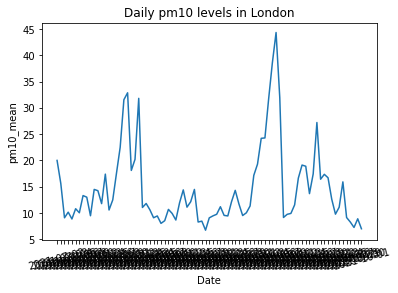

In [13]:
#plt.scatter(Measurements['Date'], Measurements['pm10_mean'])


sns.lineplot(x="Date", y="pm10_mean", data=Measurements)
plt.xticks(rotation=15)
plt.title('Daily pm10 levels in London')
plt.show()